In [1]:
%matplotlib inline

In [2]:
# import glob
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi


###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [3]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 8
matplotlib.rcParams['axes.labelsize'] = 8
matplotlib.rcParams['axes.titlesize'] = 8

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['legend.fontsize'] = 8
# matplotlib.rcParams['text.usetex'] = True

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [4]:
phages_df = pd.read_csv('../Data/NCBI_phage_db/paper_dataset_11_2020_with_clusters.tsv', sep='\t')
phages_df.head()

,Accession,SRA_Accession,Release_Date,Species,Genus,Family,Length,Sequence_Type,Nuc_Completeness,Genotype,...,Host_order_name,Host_family_id,Host_family_name,Host_genus_id,Host_genus_name,arbitrary_cluster_id,ranking_in_cluster,cluster_representative,CDS_density,CDS_number
0,NC_050154,NaN,2020-08-13T00:00:00Z,Escherichia phage D6,NaN,Myoviridae,91159,RefSeq,complete,NaN,...,Enterobacterales,543.0,Enterobacteriaceae,561.0,Escherichia,35,1,1.0,0.897366,118.0
1,NC_050143,NaN,2020-08-10T00:00:00Z,Pseudomonas phage datas,Pbunavirus,Myoviridae,60746,RefSeq,complete,NaN,...,Pseudomonadales,135621.0,Pseudomonadaceae,286.0,Pseudomonas,17,27,NaN,NaN,NaN
2,NC_050144,NaN,2020-08-10T00:00:00Z,Pseudomonas phage Epa14,Pbunavirus,Myoviridae,65797,RefSeq,complete,NaN,...,Pseudomonadales,135621.0,Pseudomonadaceae,286.0,Pseudomonas,6,1,1.0,0.908035,92.0
3,NC_050145,NaN,2020-08-10T00:00:00Z,Pseudomonas phage PaGU11,Pbunavirus,Myoviridae,65554,RefSeq,complete,NaN,...,Pseudomonadales,135621.0,Pseudomonadaceae,286.0,Pseudomonas,17,24,NaN,NaN,NaN
4,NC_050146,NaN,2020-08-10T00:00:00Z,Pseudomonas phage Epa7,Pbunavirus,Myoviridae,65629,RefSeq,complete,NaN,...,Pseudomonadales,135621.0,Pseudomonadaceae,286.0,Pseudomonas,5,3,NaN,NaN,NaN


In [5]:
host_species_list = list(set(phages_df['Host_species_id']))
print(len(host_species_list))

42


In [6]:
lifestyle_df = pd.read_csv('../Data/lifestyle_results_BACPHLIP.tsv', sep='\t')
print(lifestyle_df.shape)
lifestyle_df.head()

(2185, 4)


,host_id,phage_id,phage_lifestyle,lifestyle_probability_difference
0,1280,NC_048635,Temperate,1.000000
1,1280,NC_048644,Temperate,1.000000
2,1280,NC_047724,Virulent,0.650000
3,1280,NC_047788,Virulent,0.925000
4,1280,NC_047855,Virulent,0.986177


# First get a basic taxonomy tree

In [7]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
# ncbi.update_taxonomy_database()

In [8]:
tree = ncbi.get_topology(host_species_list)
# tree.render("%%inline")

**This is just a basic way to sort the species so that they're taxonomically grouped top to bottom**

In [9]:
phylo_listy = []
for i in tree.get_leaves():
     phylo_listy.append(int(i.name))

In [10]:
###For prettier plotting
col_to_label_dict = {'aSD_binding': 'aSD binding\nenergy (kcal/mol)',
                    'Start_accessibility': 'Start accessibility (kcal/mol)',
                    'iCUB': 'iCUB',
                    'GC_cds': 'Coding sequence GC content',
                    'sec_struct': 'Start codon\nsecondary structure\n(kcal/mol)'}

mean_col_to_label_dict = {}
for key, val in col_to_label_dict.items():
    if val[0]==val[0].upper():
        mean_col_to_label_dict[key] = 'Mean ' + val[0].lower() + val[1:]
    else:
        mean_col_to_label_dict[key] = 'Mean ' + val

# First get as many species as I can and be agnostic to phage lifestyle

In [11]:
host_genome_dir = '../Data/NCBI_phage_db/host_genomes/'
base_viral_genome_dir = '../Data/NCBI_phage_db/phage_genomes/'

col_name = 'aSD_binding'
# col_name = 'sec_struct'
# col_name = 'Start_accessibility'
# col_name = 'GC_cds'
# col_name = 'iCUB'

n_phages_cutoff = 10

host_species_names = []
all_phage_means = []
all_phage_sig = []
all_host_means = []
for host_id in phylo_listy[::-1]:
    try:
        host_df = pd.read_csv(host_genome_dir + '{}.clean.tsv'.format(host_id), sep='\t')
    except FileNotFoundError:
        print('No genome with id:', host_id)
        continue
        
    host_mean = host_df[col_name].mean()

    species_df = phages_df[(phages_df['Host_species_id']==host_id) & (phages_df['cluster_representative']==1)]
    if species_df.shape[0] < n_phages_cutoff:
        continue
    ###For the violin plot at the top
    mean_virus = []
    p_vals = []
    for index in species_df.index:
        phage_name = species_df.loc[index]['Accession']
    
        phage_file = base_viral_genome_dir+'{}_phage_genomes/{}.clean.tsv'.format(host_id, phage_name)
        phage_df = pd.read_csv(phage_file, sep='\t')
        mean_virus.append(phage_df[col_name].mean())
        t, p = stats.ttest_ind(host_df[col_name], phage_df[col_name], equal_var=False)
        p_vals.append(p)
    truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)

    all_host_means.append(host_mean)
    all_phage_means.append(mean_virus)
    l_sig = sum([i for i,j in zip(truth_array, mean_virus) if j < host_mean])
    r_sig = sum([i for i,j in zip(truth_array, mean_virus) if j > host_mean])
    all_phage_sig.append((l_sig/len(mean_virus), r_sig/len(mean_virus)))
    host_species_names.append(phages_df[phages_df['Host_species_id']==host_id].iloc[0]['Host_species_name'])
    print(host_id,
          phages_df[phages_df['Host_species_id']==host_id].iloc[0]['Host_species_name'],
          all_phage_sig[-1])

76594 Cellulophaga baltica (0.0, 0.05555555555555555)
305 Ralstonia solanacearum (0.13793103448275862, 0.034482758620689655)
No genome with id: 1708203
644 Aeromonas hydrophila (0.16666666666666666, 0.06666666666666667)
670 Vibrio parahaemolyticus (0.6785714285714286, 0.03571428571428571)
666 Vibrio cholerae (0.45, 0.0)
552 Erwinia amylovora (0.5483870967741935, 0.06451612903225806)
623 Shigella flexneri (0.84, 0.0)
573 Klebsiella pneumoniae (0.5692307692307692, 0.015384615384615385)
562 Escherichia coli (0.3228346456692913, 0.03937007874015748)
No genome with id: 599
28901 Salmonella enterica (0.4098360655737705, 0.01639344262295082)
470 Acinetobacter baumannii (0.875, 0.0)
No genome with id: 317
No genome with id: 306
287 Pseudomonas aeruginosa (0.4430379746835443, 0.0759493670886076)
1911 Streptomyces griseus (0.38235294117647056, 0.14705882352941177)
1747 Cutibacterium acnes (0.0, 0.0)
1772 Mycolicibacterium smegmatis (0.7984189723320159, 0.0)
1833 Rhodococcus erythropolis (0.54545

**Plot those results**

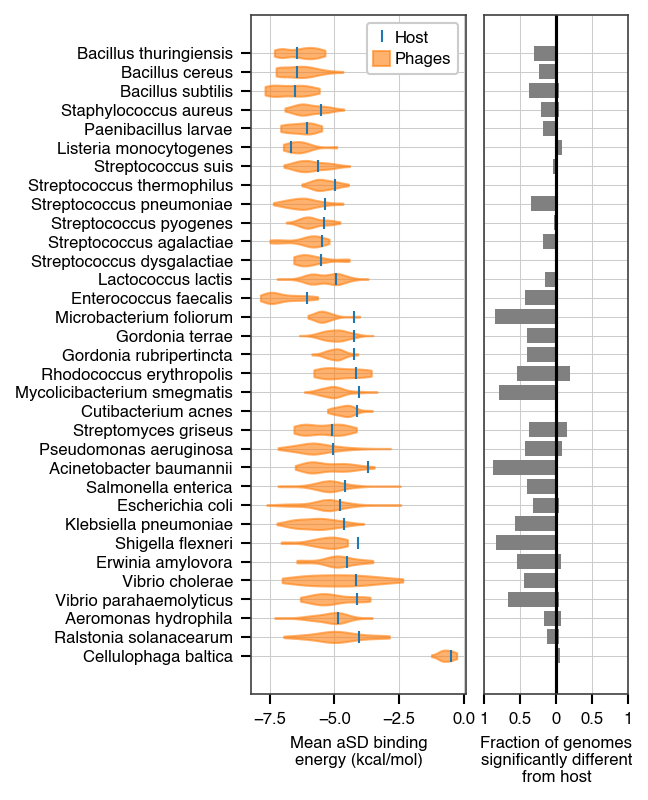

In [12]:
all_y_vals = list(np.arange(1, len(all_phage_means)+1, 1))
phage_patch = mpatches.Patch(color=colors[1], alpha=0.6, label='Phages')

fig, ax_arr = plt.subplots(figsize=(3.25,6), ncols=2, sharey=True, gridspec_kw={'width_ratios': [1.5, 1]})
###Subplot 1
vparts = ax_arr[0].violinplot(all_phage_means, widths=0.6, vert=False,
                              showextrema=False, points=20)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
    pc.set_alpha(0.6)
host_data = ax_arr[0].plot(all_host_means, all_y_vals, c=colors[0],\
            marker='|', linestyle='', zorder=2, markersize=6, mew=1, label='Host')
ax_arr[0].set_yticks(all_y_vals);
ax_arr[0].set_yticklabels(host_species_names, size=8);
ax_arr[0].set_xlabel(mean_col_to_label_dict[col_name], fontsize=8)
ax_arr[0].legend(handles=[host_data[0], phage_patch], framealpha=1.0, handlelength=1, handleheight=1, handletextpad=0.3, labelspacing=0.3)

###Subplot 2
l_bar = ax_arr[1].barh(all_y_vals, [-1*i[0] for i in all_phage_sig], height=0.8,\
             color='gray')
r_bar = ax_arr[1].barh(all_y_vals, [i[1] for i in all_phage_sig], height=0.8,\
            color='gray')
ax_arr[1].set_xticks([-1, -0.5, 0, 0.5, 1])
ax_arr[1].set_xticklabels([1, 0.5, 0, 0.5, 1])
ax_arr[1].axvline(0, c='k')
ax_arr[1].tick_params(width=0, axis='y')
ax_arr[1].set_xlabel('Fraction of genomes\nsignificantly different\nfrom host', fontsize=8)
# ax_arr[0].xticks(size=8)
plt.subplots_adjust(wspace=0.1)
plt.savefig(figs_dir + '/all_species_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

# Lifestyle splits

Next, only consider host genomes with both lifestyles and separate accordingly

In [13]:
lifestyle_phylo_listy = []
for host_id in phylo_listy:
    species_df = phages_df[(phages_df['Host_species_id']==host_id) 
                           & (phages_df['cluster_representative']==1)]
    tempy = lifestyle_df[(lifestyle_df['host_id']==host_id)]
    temp_count = tempy[(tempy['phage_lifestyle']=='Temperate') 
                  & (tempy['lifestyle_probability_difference'] > 0.95)].shape[0]
    vir_count = tempy[(tempy['phage_lifestyle']=='Virulent') 
                  & (tempy['lifestyle_probability_difference'] > 0.95)].shape[0]
    if temp_count >= 5 and vir_count >= 5:
        lifestyle_phylo_listy.append(host_id)
print(len(lifestyle_phylo_listy))    

9


In [20]:
host_genome_dir = '../Data/NCBI_phage_db/host_genomes/'
base_viral_genome_dir = '../Data/NCBI_phage_db/phage_genomes/'

# col_name = 'aSD_binding'
col_name = 'sec_struct'
# col_name = 'Start_accessibility'
# col_name = 'GC_cds'
# col_name = 'iCUB'

# lifestyle_constraint = 'Temperate'
lifestyle_constraint = 'Virulent'

host_species_names = []
all_phage_means = []
all_phage_sig = []
all_host_means = []
for host_id in lifestyle_phylo_listy[::-1]:
    host_id = int(host_id)
    try:
        host_df = pd.read_csv(host_genome_dir + '{}.clean.tsv'.format(host_id), sep='\t')
    except FileNotFoundError:
        print('No genome with id:', host_id)
        continue
        
    host_mean = host_df[col_name].mean()

    species_df = phages_df[(phages_df['Host_species_id']==host_id) & (phages_df['cluster_representative']==1)]
    
    tempy = lifestyle_df[(lifestyle_df['host_id']==host_id)]
    temp_count = tempy[(tempy['phage_lifestyle']=='Temperate') 
                  & (tempy['lifestyle_probability_difference'] > 0.95)].shape[0]
    
    ###For the violin plot at the top
    mean_virus = []
    p_vals = []
    for index in species_df.index:
        phage_name = species_df.loc[index]['Accession']
        tempy = lifestyle_df[lifestyle_df['phage_id']==phage_name]
        assert tempy.shape[0]==1
        if tempy.iloc[0]['phage_lifestyle'] != lifestyle_constraint or\
                    tempy.iloc[0]['lifestyle_probability_difference'] < 0.95:
            continue
    
        phage_file = base_viral_genome_dir+'{}_phage_genomes/{}.clean.tsv'.format(host_id, phage_name)
        phage_df = pd.read_csv(phage_file, sep='\t')
        mean_virus.append(phage_df[col_name].mean())
        t, p = stats.ttest_ind(host_df[col_name], phage_df[col_name], equal_var=False)
        p_vals.append(p)
    truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)

    all_host_means.append(host_mean)
    all_phage_means.append(mean_virus)
    l_sig = sum([i for i,j in zip(truth_array, mean_virus) if j < host_mean])
    r_sig = sum([i for i,j in zip(truth_array, mean_virus) if j > host_mean])
    all_phage_sig.append((l_sig/len(mean_virus), r_sig/len(mean_virus)))
    host_species_names.append(phages_df[phages_df['Host_species_id']==host_id].iloc[0]['Host_species_name'])
    print(host_id,
          phages_df[phages_df['Host_species_id']==host_id].iloc[0]['Host_species_name'],
          all_phage_sig[-1])

305 Ralstonia solanacearum (0.0, 0.2)
623 Shigella flexneri (0.0, 0.7857142857142857)
573 Klebsiella pneumoniae (0.0, 0.5)
562 Escherichia coli (0.028846153846153848, 0.5961538461538461)
28901 Salmonella enterica (0.0, 0.5294117647058824)
287 Pseudomonas aeruginosa (0.0, 0.7272727272727273)
1772 Mycolicibacterium smegmatis (0.0, 0.375)
1358 Lactococcus lactis (0.0, 0.0)
1280 Staphylococcus aureus (0.0, 0.4)


**Plot**

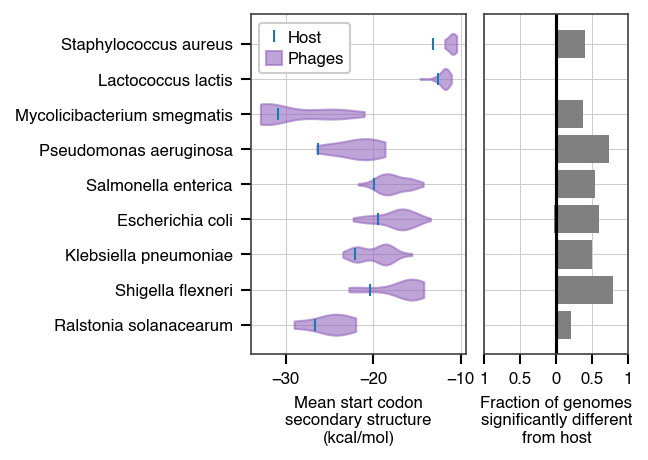

In [21]:
all_y_vals = list(np.arange(1, len(all_phage_means)+1, 1))
if lifestyle_constraint == 'Virulent':
    phage_patch = mpatches.Patch(color=colors[4], alpha=0.6, label='Phages')
elif lifestyle_constraint == 'Temperate':
    phage_patch = mpatches.Patch(color='gold', alpha=0.6, label='Phages')
else:
    print('MAJOR ERROR')
    raise Exception


fig, ax_arr = plt.subplots(figsize=(3.25,3), ncols=2, sharey=True, gridspec_kw={'width_ratios': [1.5, 1]})
###Subplot 1
vparts = ax_arr[0].violinplot(all_phage_means, widths=0.6, vert=False,
                              showextrema=False, points=20)
for pc in vparts['bodies']:
    if lifestyle_constraint == 'Virulent':
        pc.set_facecolor(colors[4])
        pc.set_edgecolor(colors[4])
        pc.set_alpha(0.6)
    elif lifestyle_constraint == 'Temperate':
        pc.set_facecolor('gold')
        pc.set_edgecolor('gold')
        pc.set_alpha(0.6)
    else:
        print('MAJOR ERROR')
        raise Exception
host_data = ax_arr[0].plot(all_host_means, all_y_vals, c=colors[0],\
            marker='|', linestyle='', zorder=2, markersize=6, mew=1, label='Host')
ax_arr[0].set_yticks(all_y_vals);
ax_arr[0].set_yticklabels(host_species_names, size=8);
ax_arr[0].set_xlabel(mean_col_to_label_dict[col_name], fontsize=8)
ax_arr[0].legend(handles=[host_data[0], phage_patch], framealpha=1.0, handlelength=1, handleheight=1, handletextpad=0.3, labelspacing=0.3)

###Subplot 2
l_bar = ax_arr[1].barh(all_y_vals, [-1*i[0] for i in all_phage_sig], height=0.8,\
             color='gray')
r_bar = ax_arr[1].barh(all_y_vals, [i[1] for i in all_phage_sig], height=0.8,\
            color='gray')
ax_arr[1].set_xticks([-1, -0.5, 0, 0.5, 1])
ax_arr[1].set_xticklabels([1, 0.5, 0, 0.5, 1])
ax_arr[1].axvline(0, c='k')
ax_arr[1].tick_params(width=0, axis='y')
ax_arr[1].set_xlabel('Fraction of genomes\nsignificantly different\nfrom host', fontsize=8)
# ax_arr[0].xticks(size=8)
plt.subplots_adjust(wspace=0.1)
plt.savefig(figs_dir + '/limited_species_{}_{}.png'.format(lifestyle_constraint, col_name), dpi=300, bbox_inches='tight')

In [37]:
lifestyle_df

,host_id,phage_id,phage_lifestyle,lifestyle_probability_difference
0,1280,NC_048635,Temperate,1.000000
1,1280,NC_048644,Temperate,1.000000
2,1280,NC_047724,Virulent,0.650000
3,1280,NC_047788,Virulent,0.925000
4,1280,NC_047855,Virulent,0.986177
...,...,...,...,...
2180,1911,MH171094,Temperate,0.875000
2181,1911,MH019216,Virulent,0.500000
2182,1911,MF975638,Virulent,0.225000
2183,1911,MF358541,Virulent,0.950000
